<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter09/Detectron2_Chapter09_TestTimeAugmentations.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 09 - Test-time Augmentations (TTA)

## Installation

In [ ]:
!python -m  pip install --q \
'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


## Datasets

In [ ]:
!wget -q https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/braintumors_coco.zip
!unzip -q braintumors_coco.zip

In [ ]:
import torch
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

In [ ]:
# Some configurations
name_ds = "braintumors_coco"
name_ds_test = name_ds + "_test"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_test = name_ds + "/test/" + af

In [ ]:
# Register datasets
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


## Get a pre-trained model

In [ ]:
output_path = "output/object_detector_hook/"

In [ ]:
!wget --quiet https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/Chapter08/object_detector_hook.zip
!unzip --q object_detector_hook.zip
!unzip --q {output_path}/model_best.pth.zip

Archive:  object_detector_hook.zip
   creating: output/object_detector_hook/
  inflating: output/object_detector_hook/events.out.tfevents.1672290421.5479d195d169.4549.0  
 extracting: output/object_detector_hook/last_checkpoint  
  inflating: output/object_detector_hook/coco_instances_results.json  
  inflating: output/object_detector_hook/cfg.pickle  
  inflating: output/object_detector_hook/metrics.json  
 extracting: output/object_detector_hook/model_best.pth.zip  
Archive:  output/object_detector_hook//model_best.pth.zip
  inflating: output/object_detector_hook/model_best.pth  


## Test-time Augmentation

In [ ]:
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 8.7 MB/s eta 0:00:00


In [ ]:
import os
import pickle5 as pickle
# get a configuration
with open(output_path + "cfg.pickle", "rb") as f:
  cfg = pickle.load(f)

In [ ]:
# current TTA settings
print("min_sizes", cfg.TEST.AUG.MIN_SIZES)
print("max_size", cfg.TEST.AUG.MAX_SIZE)
print("flip", cfg.TEST.AUG.FLIP)

min_sizes (400, 500, 600, 700, 800, 900, 1000, 1100, 1200)
max_size 4000
flip True


In [ ]:
import torch
from detectron2.data import DatasetCatalog
import detectron2.data.transforms as T
from detectron2.engine import DefaultPredictor
from detectron2.modeling.test_time_augmentation import GeneralizedRCNNWithTTA, DatasetMapperTTA
import types
# device
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE = device
# get the dataset
ds = DatasetCatalog.get(name_ds_test)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = os.path.join(output_path, 
                                 "model_best.pth")
model = DefaultPredictor(cfg).model
# use default DatasetMapperTTA
min_sizes = cfg.TEST.AUG.MIN_SIZES
max_size = cfg.TEST.AUG.MAX_SIZE
flip = cfg.TEST.AUG.FLIP
tta_mapper = DatasetMapperTTA(min_sizes, max_size, flip)
# the tta model
tta_model = GeneralizedRCNNWithTTA(
    cfg, model, 
    tta_mapper = tta_mapper,
    batch_size = cfg.SOLVER.IMS_PER_BATCH)
with torch.no_grad():
  ret = tta_model(ds)

[01/10 09:25:00 d2.data.datasets.coco]: Loaded 223 images in COCO format from braintumors_coco/test/_annotations.coco.json
[01/10 09:25:02 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (6

/home/pham/anaconda3/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Qualitative Evaluation with Visualization

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2

def imshow(image):
  dpi = plt.rcParams["figure.dpi"]
  im_data = image[:,:, ::-1]
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(im_data)
  plt.imshow(im_data)
  plt.axis("off")
  plt.show()

def visualize_output(img, output, cfg, scale=1.0):
  v = Visualizer(img[:, :, ::-1], 
                 MetadataCatalog.get(cfg.DATASETS.TEST[0]), 
                 scale=scale)
  annotated_img = v.draw_instance_predictions(
      output["instances"].to("cpu"))
  imshow(annotated_img.get_image())

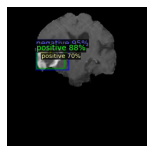

{'instances': Instances(num_instances=3, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[ 52.7345,  62.3590, 112.4091, 115.9074],
        [ 54.1637,  70.4607, 105.0336, 114.4673],
        [ 62.5844,  69.7170,  79.4941,  87.2545]], device='cuda:0')), scores: tensor([0.9533, 0.8784, 0.7020], device='cuda:0'), pred_classes: tensor([0, 1, 1], device='cuda:0')])}


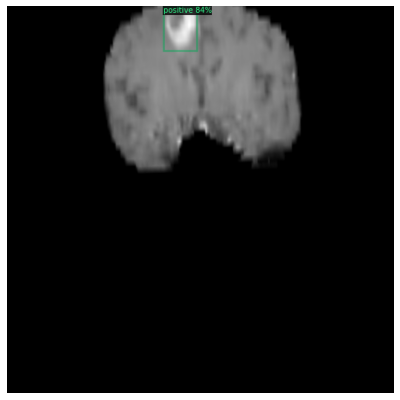

{'instances': Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[206.5809,   1.2076, 250.9124,  58.8141]], device='cuda:0')), scores: tensor([0.8359], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


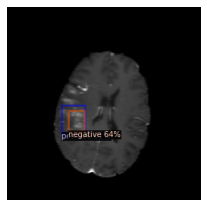

{'instances': Instances(num_instances=2, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[ 80.9797, 138.0245, 101.5485, 165.1798],
        [ 72.4728, 130.6738, 102.9652, 166.9844]], device='cuda:0')), scores: tensor([0.6440, 0.6058], device='cuda:0'), pred_classes: tensor([0, 1], device='cuda:0')])}


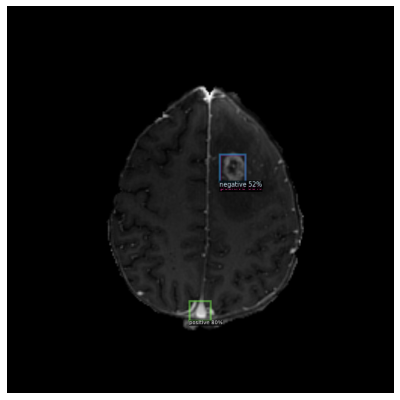

{'instances': Instances(num_instances=3, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[241.2052, 390.4835, 269.0475, 416.3400],
        [282.1091, 197.4752, 315.3445, 236.3738],
        [281.3650, 195.9819, 315.0314, 231.9766]], device='cuda:0')), scores: tensor([0.8021, 0.6775, 0.5208], device='cuda:0'), pred_classes: tensor([1, 1, 0], device='cuda:0')])}


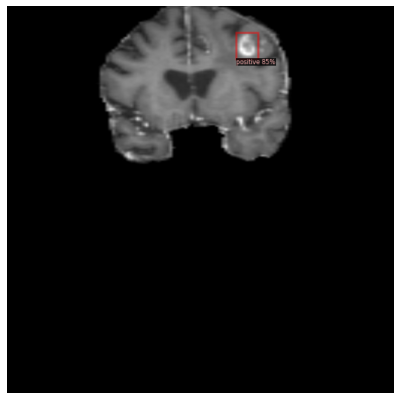

{'instances': Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[303.4203,  34.9643, 331.9926,  69.5519]], device='cuda:0')), scores: tensor([0.8503], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


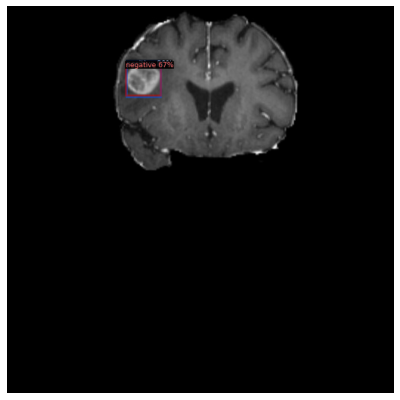

{'instances': Instances(num_instances=2, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[157.5761,  72.1055, 203.0936, 119.5892],
        [156.7533,  73.6279, 202.9134, 117.6436]], device='cuda:0')), scores: tensor([0.8017, 0.6658], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0')])}


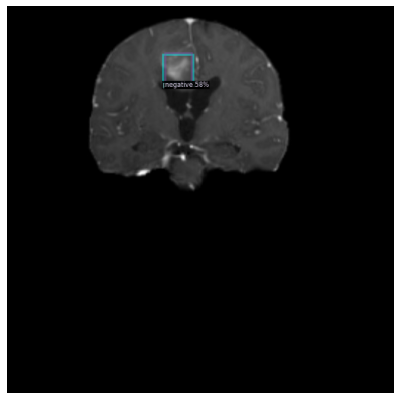

{'instances': Instances(num_instances=2, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[206.1576,  64.3798, 246.4071, 100.0059],
        [209.0167,  62.4419, 243.8053,  99.8803]], device='cuda:0')), scores: tensor([0.6200, 0.5779], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0')])}


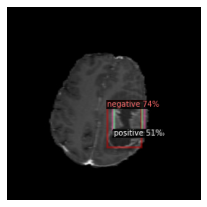

{'instances': Instances(num_instances=3, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[132.1786, 125.0797, 177.0470, 186.3525],
        [139.1987, 128.0201, 181.1326, 163.2605],
        [140.7319, 127.1251, 178.1419, 162.5285]], device='cuda:0')), scores: tensor([0.7380, 0.5747, 0.5066], device='cuda:0'), pred_classes: tensor([0, 0, 1], device='cuda:0')])}


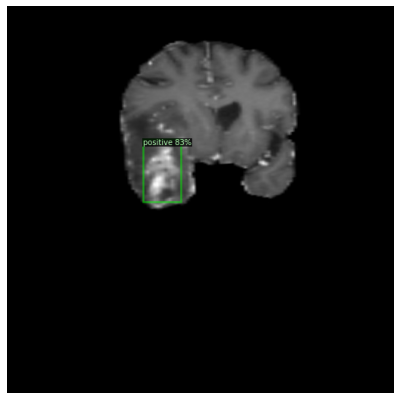

{'instances': Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[179.8867, 175.7860, 229.9514, 259.0896]], device='cuda:0')), scores: tensor([0.8277], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


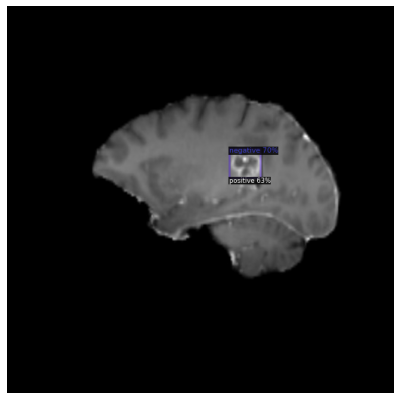

{'instances': Instances(num_instances=2, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[293.5469, 187.1768, 336.9187, 232.7913],
        [293.5217, 188.1516, 335.0538, 226.7469]], device='cuda:0')), scores: tensor([0.7049, 0.6283], device='cuda:0'), pred_classes: tensor([0, 1], device='cuda:0')])}


In [ ]:
# let's visualize some
import numpy as np
for idx in np.random.randint(0, len(ds), 10):
  img = cv2.imread(ds[idx]['file_name'])
  output = ret[idx]
  visualize_output(img, output, cfg)
  print(output)